In [1]:
#Import all the required libraries

import pandas as pd
import numpy as np
import pandas_datareader.data as fetch
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm, pyplot as plt, finance
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sbn
from hmmlearn.hmm import GaussianHMM

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Define a function to fetch the 'Adjusted Close' price of a stock for a range of dates

def adj_close(symbols, start_date, end_date):
    stock_adj_close = pd.DataFrame()
    for s in symbols:
        data = fetch.DataReader(s, 'yahoo', start_date, end_date)
        stock_adj_close[s] = data['Adj Close']
    return stock_adj_close

In [4]:
# Define a function to fetch the 'Volume' of a stock for a range of dates

def volume_stock(symbols, start_date, end_date):
    stock_volume_df = pd.DataFrame()
    for s in symbols:
        data = fetch.DataReader(s, 'yahoo', start_date, end_date)
        stock_volume_df[s] = data['Volume']
    return stock_volume_df

In [5]:
# Import the adjusted closing price and volume for Walmart from 2000 to 2017

start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2017, 12, 31)
symbols = ['WMT']
adj_close_portfolio = adj_close(symbols, start_date, end_date)
volume_portfolio = volume_stock(symbols, start_date, end_date)

In [6]:
# Reset the index

adj_close_portfolio.reset_index(inplace=True,drop=False)
volume_portfolio.reset_index(inplace=True,drop=False)

In [7]:
# Create a single dataset with the date, ajusted closing price and the volume details

final_df = adj_close_portfolio
final_df.columns = ['Date', 'Adj_Close']
final_df['Volume'] = volume_portfolio['WMT']

In [8]:
# Convert date to oridinal format and the final dataset to tuple

final_df['Date'] = final_df['Date'].apply(datetime.datetime.toordinal)

In [9]:
final_df_list = list(final_df.itertuples(index=False, name=None))

In [10]:
final_df_list

[(730119, 50.131423999999996, 2112700),
 (730122, 48.45433, 8369900),
 (730123, 46.641258, 6745100),
 (730124, 45.689392, 7018700),
 (730125, 46.188, 6544500),
 (730126, 49.678146000000005, 7976900),
 (730129, 48.771622, 6714300),
 (730130, 48.046387, 4943300),
 (730131, 47.185177, 4085000),
 (730132, 47.230507, 5021000),
 (730133, 46.777245, 6312200),
 (730137, 47.547779, 6442200),
 (730138, 46.459942, 4819900),
 (730139, 45.961357, 5738100),
 (730140, 45.281452, 6952500),
 (730143, 43.060444, 7799900),
 (730144, 44.329594, 6403800),
 (730145, 44.918831, 4538400),
 (730146, 42.879139, 7323300),
 (730147, 39.978226, 14029400),
 (730150, 39.706253000000004, 7972700),
 (730151, 42.561855, 8359000),
 (730152, 42.335213, 6034600),
 (730153, 42.335213, 6999000),
 (730154, 40.839436, 6549700),
 (730157, 40.43148, 6043700),
 (730158, 43.151089, 8576100),
 (730159, 41.927273, 8216600),
 (730160, 41.338024, 4591600),
 (730161, 40.658122999999996, 4816700),
 (730164, 42.697829999999996, 5803600)

In [11]:
# Create dates, adjusted closing price and volume variables

dates = np.array([q[0] for q in final_df_list], dtype=int)
close_v = np.array([q[1] for q in final_df_list])
volume = np.array([q[2] for q in final_df_list])[1:]

In [12]:
# Calculate the difference between the closing prices of 2 consecutive days.
# Note that this would result in one less value that the number of dates or volumes
# Dates and volumes are shifted by 1 to adjust this change

diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

In [13]:
# Pack diff and volume for training

X = np.column_stack([diff, volume])

In [14]:
diff.shape, volume.shape, dates.shape, close_v.shape

((4528,), (4528,), (4528,), (4528,))

In [15]:
X.shape
X[0]

(4528, 2)

array([ -1.67709400e+00,   8.36990000e+06])

Text(0.5,1,'Walmart - 12/31/2017')

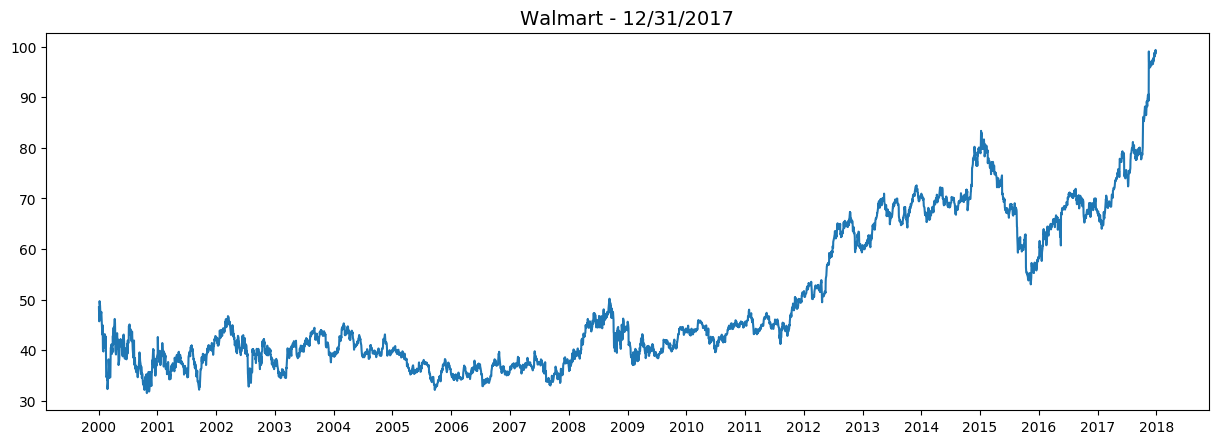

In [16]:
# Plot the stock trend for Walmart

plt.figure(figsize=(15, 5), dpi=100) 
plt.title('Walmart' + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

In [17]:
# Run the Gaussian HMM model
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

/home/pavan/anaconda3/envs/ubuntu_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
# Print the trained model parameters

print("Transition matrix - probability of going to any particular state")
print(model.transmat_)
print()
print(model.predict_proba)
print()
print("Means and vars of each hidden state")
params = pd.DataFrame(columns=('State', 'Means', 'Variance'))
for i in range(model.n_components):
    params.loc[i] = [format(i), model.means_[i],np.diag(model.covars_[i])]
params

Transition matrix - probability of going to any particular state
[[  8.43384610e-01   9.24862731e-04   1.46150664e-01   9.53986292e-03]
 [  3.44016604e-15   9.28955940e-01   1.27791540e-02   5.82649063e-02]
 [  2.32456458e-01   2.70863316e-03   7.36071478e-01   2.87634311e-02]
 [  1.25576876e-24   1.61161541e-01   6.27544873e-02   7.76083971e-01]]

<bound method _BaseHMM.predict_proba of GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)>

Means and vars of each hidden state


,State,Means,Variance
0,0,"[0.00775714578909, 6450801.1766]","[0.212576392396, 1.93503022357e+12]"
1,1,"[0.0169021018113, 13316875.9971]","[0.117447195367, 1.36701043408e+13]"
2,2,"[0.0374384958289, 9889710.0642]","[0.78247061965, 5.62178729275e+12]"
3,3,"[-0.048201117554, 24633348.5241]","[1.49960018697, 9.00860911574e+13]"


Text(0.5,1,'0th hidden state')

Text(0.5,1,'1th hidden state')

Text(0.5,1,'2th hidden state')

Text(0.5,1,'3th hidden state')

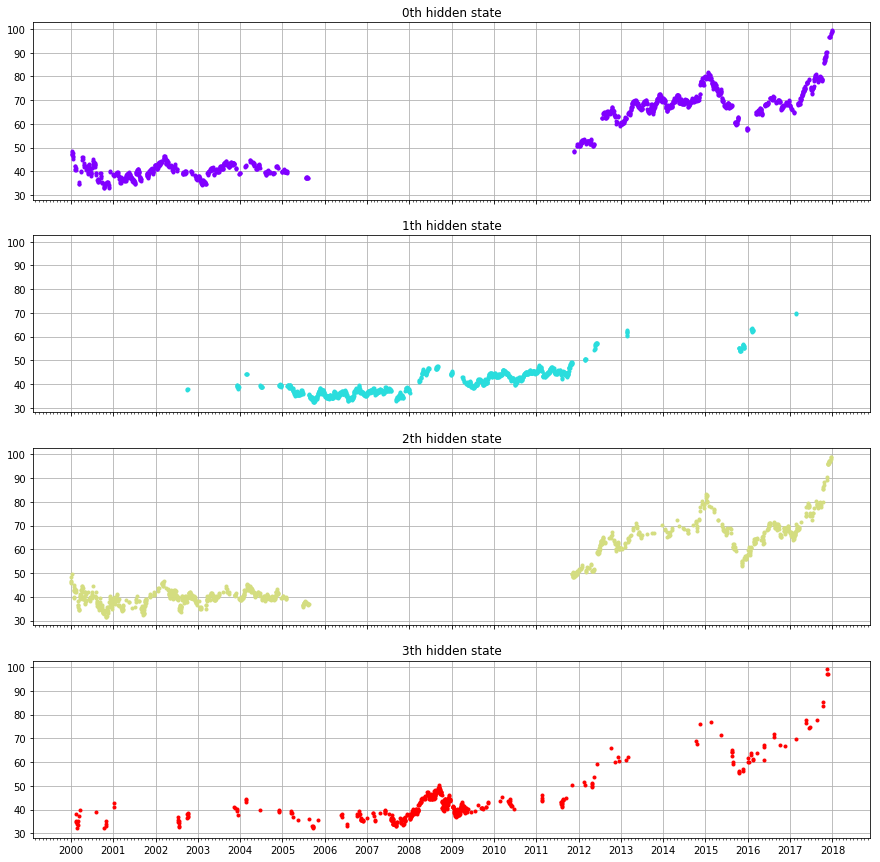

In [19]:
# Plot each hidden state

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

In [20]:
# Dot product Transition Matrix to Means to get the expected return and volumes for a particular state

expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns        Volume
0  0.011570  7.133209e+06
1  0.013371  1.393243e+07
2  0.028020  9.523674e+06
3 -0.032335  2.188434e+07


In [21]:
# Get stock details for last N days

lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in final_df_list], dtype=int)

In [22]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = final_df_list[-lastN+idx][1]
    volume = final_df_list[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))

Text(0.5,1,'Walmart')

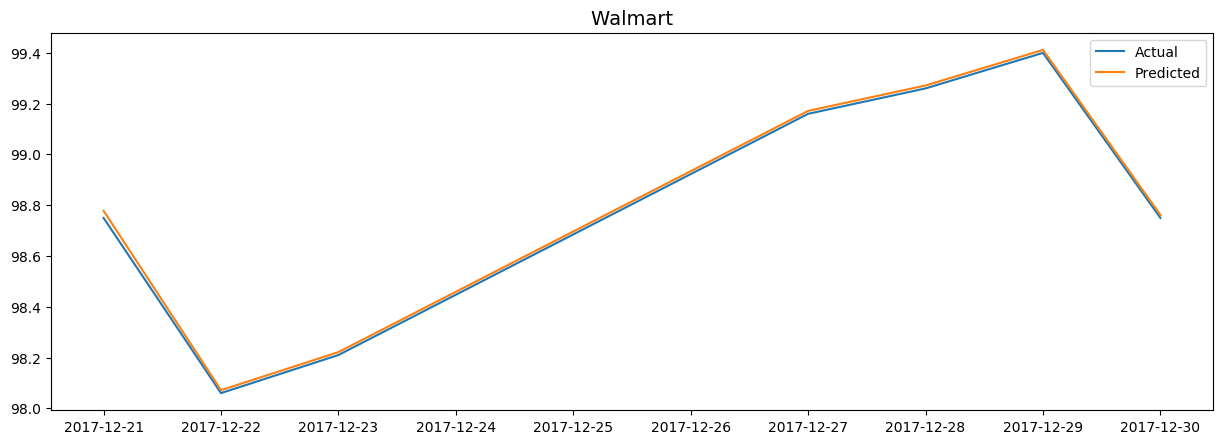

In [23]:
# Plot the predicted returns

plt.figure(figsize=(15, 5), dpi=100) 
plt.title('Walmart', fontsize = 14)
plt.plot(predicted_dates,close_v[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()